# Análise temporal COVID-19 Brasil 

# Escopo do projeto

* __1-Introdução__
* __2-Importação dos pacotes__
* __3-Funções__
* __4-Limpeza dos dados brutos__
* __5-Leitura dos dados limpos__
* __6-Hipóteses__
* __7-Visualização dos dados__
* __8-Modelo do Prophet__
* __9-Conclusões__

# 1 - Introdução

A pandemia causada pelo novo coronavírus (SARS-CoV-2) está sendo responsável por diversos desafios e adversidades dia após dia enfrentados pela área da saúde no mundo. No Brasil, esse vírus, levou o país a uma crise sanitária por conta de sua rápida trasmissão por todo o país, afetando a vida de milhões de pessoas. Dentre essas pessoas estão aquelas responsáveis por fornecer os cuidados e os tratamentos responsáveis por salvar vidas, e, como o Brasil é o quinto maior país do mundo e, segundo estimativas da ONU, é a sexta maior população mundial, o controle de um vírus com essas características se torna muito mais complicado.

Pensando nisso, a análise teve como objetivo encontrar padrões nas notificações dos casos e óbitos por COVID-19, tentando entender se existe alguma forma de prever os dias onde a demanda de profissionais de saúde e de recursos precisa ser maior.

### __Séries Temporais__

Uma série temporal é uma observação de uma variável ao longo do tempo, ao se analisar uma série temporal devemos procurar se existe alguma dependência da variável e do período temporal e tentar achar os possíveis padrões.Muitas vezes, se encontrados esses padrões, podemos descrever uma série temporal através de funções matemáticas que podem ser úteis nas tomadas de decisões. 

No contexto da COVID-19, se analisarmos os números de casos e óbitos em relação ao dia de notificação podemos considerar esses dados constituindo uma série temporal e, a partir disso, usar técnicas apropriadas a esse tipo de dados para tentar descrever seu comportamento ao decorrer do tempo.

#### Mas como isso pode ser útil?

Entender se existe um padrão dentro da notificação de casos pode ajudar o planejamento de Hospitais e dos órgãos de sáude para perceber uma eventual demanda maior em determinadas épocas e com isso tentar melhorar a logística de equipamentos, leitos e de profissionais.

### __Sazonalidade__

A sazonalidade é um fator crucial na hora de analisar séries temporais, ela nos ajuda a entender os padrões, podendo assumir diferentes comportamnetos, por exemplo:

* Sazonalidade semanal : os dados variam de acordo com o dia da semana
* Sazonalidade mensal : os dados variam de acordo com o dia do mês
* Sazonalidade anual : os dados variam de acordo com a época do ano

Além disso existem diversos outros fatores temporais que podem influenciar os dados, como por exemplo feriados.

# 2 - Importação dos pacotes

In [1]:
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from plot import plot_time_series, million_formatter,thousand_formatter, percent_formatter, apresentacao
from model import Modelo_prophet_semanal
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Setando parâmetros do matplotlib
mlt.rcParams['font.size'] = 18
mlt.rcParams['figure.figsize'] = (16,8)

# 3 - Funções

Aqui estão as funções auxiliares utilizadas no projeto:

In [3]:
help(Modelo_prophet_semanal)

Help on class Modelo_prophet_semanal in module model:

class Modelo_prophet_semanal(builtins.object)
 |  Modelo_prophet_semanal(dados: pandas.core.frame.DataFrame, teste_periodo: int = 0, holiday=True, pais: str = 'BR', regressors=[], **kwargs_model)
 |  
 |  Parâmetros Construtor:
 |  ---------------------
 |  dados : DataFrame com duas colunas de nome 'ds'(tipo datetime) e 'y'(tipo int ou float)
 |  teste_periodo : número inteiro representando o número de dias destinado para o teste
 |  **Kwargs_model : argumentos adicionais passados para a classe fbprophet.Prophet na hora de criar o modelo
 |  
 |  Atributos:
 |  ---------
 |  Definidos no construtor:
 |  -----------------------
 |      treino : dataset destinado aos dados de treino
 |      teste : dataset destinado aos dados de teste
 |      modelo : modelo do tipo fbprophet.Prophet
 |      previsao : previsao do modelo sobre dados de treino e teste
 |      
 |  Definido pela função c_valid():
 |  ------------------------------
 | 

In [4]:
help(plot_time_series)

Help on function plot_time_series in module plot:

plot_time_series(df: pandas.core.frame.DataFrame, title: str = '', subtitle: str = '', xlabel: str = '', ylabel: str = '', show: bool = False, ax=None, month_freq: int = 2, formatter_x=None, formatter_y=None, fonte: str = 'https://brasil.io/dataset/covid19/caso_full/', spines_invisible: list = ['top', 'right'], ylim: list = None, xlim: list = None, kwargs_grid: dict = {'axis': 'y', 'alpha': 0.6}, **kwargs_lineplot)
    Função que plota uma série temporal com os dados relacionados ao tempo no eixo x e os dados numéricos no eixo y
    
    Parâmetros:
    ----------
    df : DataFrame do pandas a serem passados os gráfico, precisa ter 2 colunas, uma com dados do tipo datetime e outra com dados numéricos, tipo : pandas.DataFrame, argumento obrigatótio
    title : título do gráfico, tipo : str, padrão : ''
    subtitle : subtítulo do gráfico, tipo : str, padrão : ''
    xlabel : rótulo do eixo x, tipo : str, padrão : ''
    ylabel : rótulo

In [5]:
help(million_formatter)

Help on function million_formatter in module plot:

million_formatter(x, pos)
    Função responsável por formatar um eixo do 'matplotlib' dividindo os valores por Milhão, 
    mostrando duas casas decimais depois da vírgula e colocando a palavra 'Mi' após os valores indicando a grandeza,
    precisa ser passada como parâmetro para a função FuncFormatter do matplotlib.ticker



In [6]:
help(thousand_formatter)

Help on function thousand_formatter in module plot:

thousand_formatter(x, pos)
    Função responsável por formatar um eixo do 'matplotlib' dividindo os valores por Mil, 
    mostrando duas casas decimais depois da vírgula e colocando a palavra 'Mil' após os valores indicando a grandeza,
    precisa ser passada como parâmetro para a função FuncFormatter do matplotlib.ticker



In [7]:
million_formatter = FuncFormatter(million_formatter)
thousand_formatter = FuncFormatter(thousand_formatter)
percent_formatter = FuncFormatter(percent_formatter)

# 4 - Limpeza dos dados brutos

Os dados foram extraídos do [Brasil.IO](https://brasil.io/dataset/covid19/caso_full/) e foram tratados no notebook [Limpeza_dados_covid](https://github.com/PedroHCAlmeida/analise_temporal_COVID_Brasil/blob/main/notebooks/Limpeza_dados_covid.ipynb), esses dados estão divididos em 18 colunas, são elas:

* city : cidade
* city_ibge_code : código da cidade
* date : data das observações
* epidemiological_week : semana epidemiológica
* estimated_population : população estimada
* estimated_population_2019 : população estimada de 2019
* is_last : indica se os dados de relacionados ao last_avaiable são realmente os últimos
* is_repeated : se os valores são repeditos
* last_available_confirmed : última atualização do número total de casos confirmados
* last_available_confirmed_per_100k_inhabitants : última atualização do número total de casos confirmados por 100 mil habitantes
* last_available_date : data da última atualização
* last_available_death_rate : última atualização da taxa de mortes
* last_available_deaths : última atualização do número total de mortes confirmados
* order_for_place : 
* place_type : tipo de local, estado ou cidade
* state : sigla do estado correspondente
* new_confirmed : casos novos notificados no dia
* new_deaths : óbitos novos notificados no dia

# 5 - Leitura dos dados limpos

## Dados limpos

Após a limpeza dos dados brutos foram usadas as colunas de casos novos e de óbitos novos por dia para calcular o total por dia no Brasil, além disso foram criadas as colunas de média móvel de 7 dias para os dados de casos e óbitos e uma coluna com a "letalidade" naquela mÊs, que na verdade são os n;umeros de óbitos somados no país no mês dividido pelo número de casos no mesmo mês.

Colunas dos dados limpos:

* date : data relacionada ao número de casos e óbitos
* casos_novos : número de casos notificados no dia
* obitos_novos : número de óbitos notificados no dia
* MM7_casos : média móvel de 7 dias dos casos novos
* MM7_obitos : média móvel de 7 dias dos casos novos
* mes/ano : mes e ano correspondentes
* letalidade_mes : número de óbitos totais do mês divididos pelo número de casos notificados no mês

In [8]:
dados_br = pd.read_csv('../dados_limpos/dados_br', parse_dates=['date'])

# 6 - Hipóteses 

* A média móvel de 7 dias de casos por dia em 2021 ultrapassou o pico de casos em 2020
* A média móvel de 7 dias de óbitos por dia em 2021 ultrapassou o pico de óbitos em 2020
* Nos finais de semana os casos notificados são menores do que no meio da semana
* Existe uma correlação entre o número de óbitos no dia e o número de casos em dias anteriores

# 7 - Visualização dos dados

In [9]:
dados_br.head()

,date,epidemiological_week,casos_novos,obitos_novos,MM7_casos,MM7_obitos,mes,letalidade_mes
0,2020-02-25,202009,1,0,NaN,NaN,02-2020,0.0
1,2020-02-26,202009,0,0,NaN,NaN,02-2020,0.0
2,2020-02-27,202009,0,0,NaN,NaN,02-2020,0.0
3,2020-02-28,202009,1,0,NaN,NaN,02-2020,0.0
4,2020-02-29,202009,0,0,NaN,NaN,02-2020,0.0


In [10]:
dados_br.tail()

,date,epidemiological_week,casos_novos,obitos_novos,MM7_casos,MM7_obitos,mes,letalidade_mes
477,2021-06-16,202124,86528,2702,72096.285714,2026.142857,06-2021,0.028272
478,2021-06-17,202124,76492,2292,69988.857143,1995.714286,06-2021,0.028272
479,2021-06-18,202124,92889,2451,70928.428571,2034.857143,06-2021,0.028272
480,2021-06-19,202124,80489,2252,71887.857143,2074.571429,06-2021,0.028272
481,2021-06-20,202125,42596,978,72689.571429,2054.285714,06-2021,0.028272


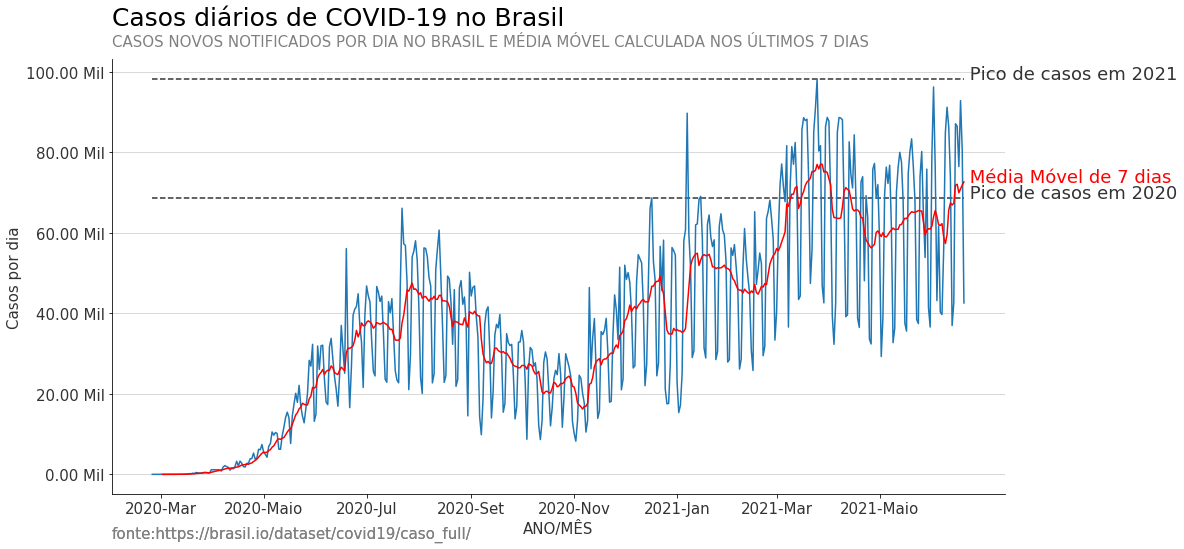

In [11]:
ax_casos=plot_time_series(dados_br[['casos_novos', 'date']])
plot_time_series(dados_br[['MM7_casos', 'date']],'Casos diários de COVID-19 no Brasil', 
                 'CASOS NOVOS NOTIFICADOS POR DIA NO BRASIL E MÉDIA MÓVEL CALCULADA NOS ÚLTIMOS 7 DIAS', color='red', ax=ax_casos, 
                 xlabel='ANO/MÊS', ylabel='Casos por dia', formatter_y=thousand_formatter)
plt.hlines(max(dados_br[dados_br['date'].dt.year == 2020].dropna()['casos_novos']), min(dados_br['date']), max(dados_br['date']), linestyle='--', alpha=0.8)
plt.annotate(' Pico de casos em 2020', (dados_br['date'].iloc[-1],max(dados_br[dados_br['date'].dt.year == 2020].dropna()['casos_novos'])), color='black', alpha=0.8)
plt.annotate(' Média Móvel de 7 dias', (dados_br['date'].iloc[-1],dados_br['MM7_casos'].iloc[-1]), color='red')
plt.hlines(max(dados_br.dropna()['casos_novos']), min(dados_br['date']), max(dados_br['date']), linestyle='--', alpha=0.8)
plt.annotate(' Pico de casos em 2021', (dados_br['date'].iloc[-1],max(dados_br.dropna()['casos_novos'])), color='black', alpha=0.8)
plt.show()

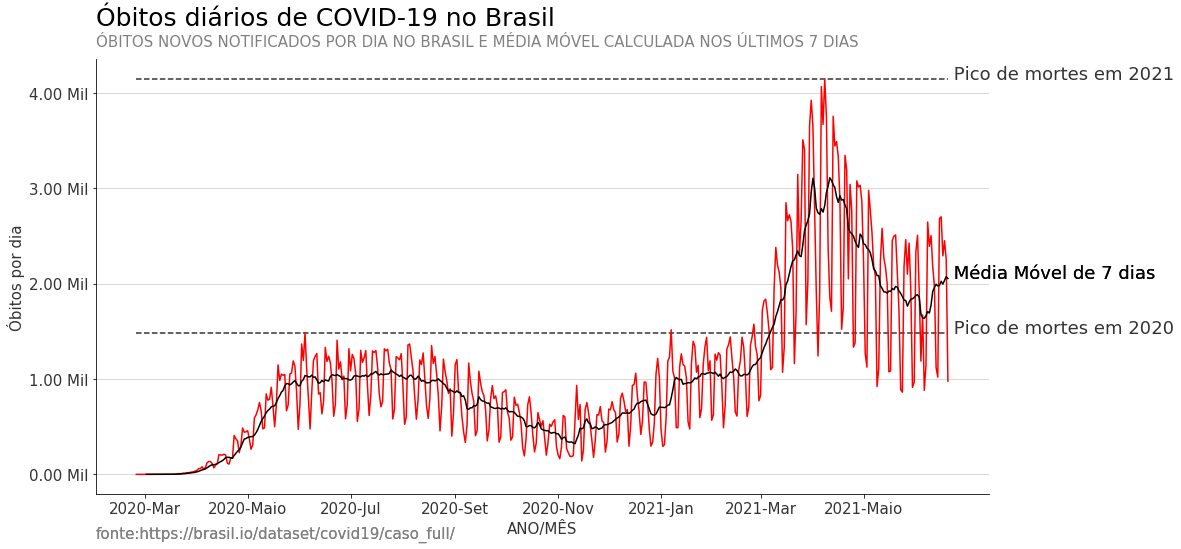

In [12]:
ax_obitos=plot_time_series(dados_br[['obitos_novos', 'date']], color='red')
plot_time_series(dados_br[['MM7_obitos', 'date']],'Óbitos diários de COVID-19 no Brasil',
                 'ÓBITOS NOVOS NOTIFICADOS POR DIA NO BRASIL E MÉDIA MÓVEL CALCULADA NOS ÚLTIMOS 7 DIAS', color='black', ax=ax_obitos, 
                 xlabel='ANO/MÊS', ylabel='Óbitos por dia',formatter_y=thousand_formatter)
plt.hlines(max(dados_br[dados_br['date'].dt.year == 2020]['obitos_novos']), min(dados_br['date']), max(dados_br['date']), linestyle='--', alpha=0.8)
plt.annotate(' Pico de mortes em 2020', (dados_br['date'].iloc[-1],max(dados_br[dados_br['date'].dt.year == 2020]['obitos_novos'])), color='black', alpha=0.8)
plt.hlines(max(dados_br.dropna()['obitos_novos']), min(dados_br['date']), max(dados_br['date']), linestyle='--', alpha=0.8)
plt.annotate(' Pico de mortes em 2021', (dados_br['date'].iloc[-1],max(dados_br.dropna()['obitos_novos'])), color='black', alpha=0.8)
plt.annotate(' Média Móvel de 7 dias', (dados_br['date'].iloc[-1],dados_br['MM7_obitos'].iloc[-1]), color='black')
plt.annotate(' Média Móvel de 7 dias', (dados_br['date'].iloc[-1],dados_br['MM7_obitos'].iloc[-1]), color='black')
plt.show()

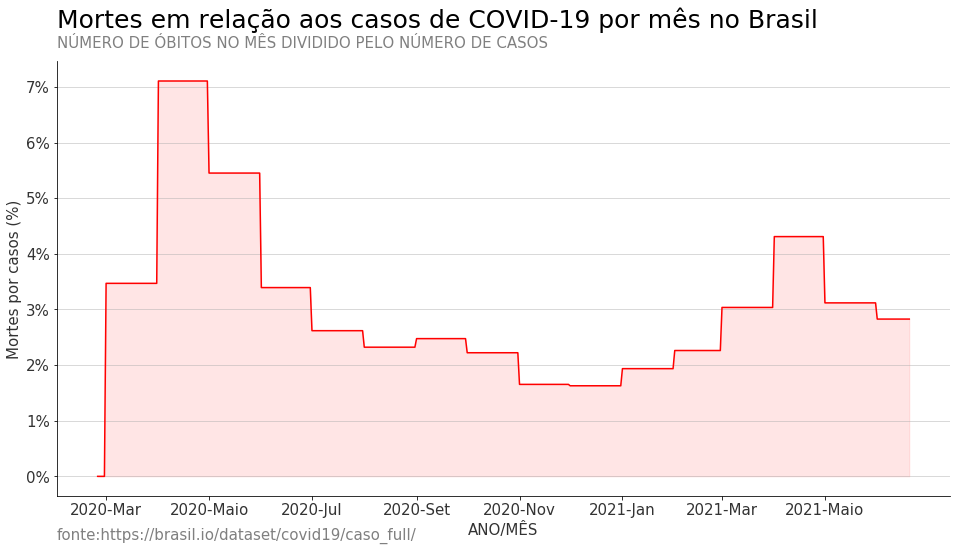

In [13]:
plot_time_series(dados_br[['letalidade_mes', 'date']],'Mortes em relação aos casos de COVID-19 por mês no Brasil', 'NÚMERO DE ÓBITOS NO MÊS DIVIDIDO PELO NÚMERO DE CASOS', 
                 xlabel='ANO/MÊS', ylabel='Mortes por casos (%)',formatter_y=percent_formatter, color='red')
plt.fill_between(dados_br['date'], dados_br['letalidade_mes'], color='red', alpha=0.1)
plt.show()

In [14]:
df_corr = pd.DataFrame()
dias_antes = []
corr = []

for i in range(1,22):
    dias_antes.append(i)
    corr.append(dados_br['obitos_novos'].corr(dados_br['casos_novos'].shift(i), method='spearman'))
df_corr['Casos_XDias_antes'] = dias_antes
df_corr['Correlacao_obitos'] = corr
df_corr = df_corr.set_index('Casos_XDias_antes')
df_corr

,Correlacao_obitos
Casos_XDias_antes,
1,0.762410
2,0.617477
3,0.562434
4,0.576296
5,0.638316
6,0.780225
7,0.860328
8,0.738217
9,0.602470


# 6 - Modelos de previsões

## 6.1 - Tipo de modelo

A fim de encontrar os padrões temporais será utilizado o pacote [fbprophet](), esse pacote possui um forecaster com um foco específico para séries temporais, primeiramente vamos partir do pressuposto que existe uma sazonalidade semanal na notificação de casos e óbitos por COVID-19, e a partir dessa hipótese analisar as previsões do Prophet para descobrir se há fatores que corroboram com essa hipótese ou não.

## 6.2 - Métricas escolhidas

As métricas escolhidas para se analisar a performance do modelo e escolher os melhores paraâmetros serão a MAE(erro médio absoluto) e a RMSE(raíz do erro médio ao quadrado), eu escolhi essas duas métricas pois acredito que são mais claras para interpretação uma vez que a unidade delas é a mesma que a variável analisada. Além disso, a RMSE é mais sensível aos erros maiores, enquanto a MAE não, ou seja, analisar a diferença entre as duas métricas pode ajudar a perceber se existe um impacto grande ou não dos outliers(valores extremos que podem gerar erros mais altos), portanto o nosso objetivo será otimizar os parâmetros primeiramente a fim de baixar a média das duas métricas e depois disso tentar retirar outliers a fim de diminuir a diferença das duas métricas.

## 6.3 - Modelo para prever casos por dia de COVID-19 no Brasil

### 6.3.1 - Problema a ser resolvido

O primeiro modelo terá como foco prever os casos novos por dia de COVID-19 no Brasil

### 6.3.2 - Modelo mais simples

A fim de ter um ponto de partida como referência para realizar as melhoras do modelo será criado o modelo mais simples possível pelo Prophet a partir dos dados de casos novos por dia de COVID-19 no Brasil.

In [15]:
dados_casos = dados_br[['date', 'casos_novos']]
dados_casos.columns = ['ds', 'y']

In [16]:
modelo_casos_simples = Modelo_prophet_semanal(dados_casos)
modelo_casos_simples.c_valid(initial='180 days', period='30 days', horizon='30 days')
modelo_casos_simples.metricas()
modelo_casos_simples.metricas

  0%|          | 0/10 [00:00<?, ?it/s]

,horizon,rmse,mae,media_metricas,diff_rmse_mae
0,3 days,13412.22061,10990.509253,12201.364932,2421.711357
1,4 days,13723.039162,12027.803867,12875.421514,1695.235295
2,5 days,13870.043513,11808.571136,12839.307324,2061.472377
3,6 days,13663.126222,10740.448109,12201.787166,2922.678113
4,7 days,13120.7422,9827.777536,11474.259868,3292.964665
5,8 days,12239.096452,9294.313198,10766.704825,2944.783254
6,9 days,11595.280348,9219.392357,10407.336352,2375.887991
7,10 days,12640.751136,10208.823766,11424.787451,2431.92737
8,11 days,15310.851087,12518.940419,13914.895753,2791.910669
9,12 days,16373.756481,13628.580827,15001.168654,2745.175654


## 6.4 - Modelo para previsão de óbitos por COVID-19 no Brasil

### 6.4.1 - Problema a ser resolvido

### 6.4.2 - Modelo mais simples

A fim de ter um ponto de partida como referência para realizar as melhoras do modelo será criado o modelo mais simples possível pelo Prophet a partir dos dados de óbitos novos por dia de COVID-19 no Brasil.

In [17]:
dados_obitos = dados_br[['date', 'obitos_novos']]
dados_obitos.columns = ['ds', 'y']

In [18]:
modelo_obitos_simples = Modelo_prophet_semanal(dados_obitos)
modelo_obitos_simples.c_valid(initial='180 days', period='7 days', horizon='7 days')
modelo_obitos_simples.metricas()
modelo_obitos_simples.metricas

  0%|          | 0/43 [00:00<?, ?it/s]

,horizon,rmse,mae,media_metricas,diff_rmse_mae
0,1 days,619.087759,408.094826,513.591292,210.992932
1,2 days,534.519279,375.548868,455.034074,158.970411
2,3 days,473.254874,337.493388,405.374131,135.761486
3,4 days,561.764382,422.437542,492.100962,139.32684
4,5 days,556.147482,378.499766,467.323624,177.647717
5,6 days,499.061311,356.128306,427.594808,142.933005
6,7 days,659.285093,424.657829,541.971461,234.627264
media,NaT,557.588597,386.122932,471.855765,171.465665


In [19]:
dados_obitos['casos_7dias_antes'] = dados_br['casos_novos'].shift(21)
dados_obitos = dados_obitos.dropna()
modelo = Modelo_prophet_semanal(dados_obitos, regressors = ['casos_7dias_antes'])
modelo.c_valid(initial='180 days', period='7 days', horizon='7 days')
modelo.metricas()
modelo.metricas

  0%|          | 0/40 [00:00<?, ?it/s]

,horizon,rmse,mae,media_metricas,diff_rmse_mae
0,1 days,479.617784,314.185009,396.901396,165.432774
1,2 days,484.297746,326.126867,405.212306,158.170879
2,3 days,422.918042,297.011861,359.964951,125.906181
3,4 days,513.24889,364.782051,439.01547,148.46684
4,5 days,549.581427,377.307544,463.444486,172.273883
5,6 days,483.935251,354.966771,419.451011,128.96848
6,7 days,516.297913,343.969719,430.133816,172.328194
media,NaT,492.842436,339.76426,416.303348,153.078176


In [20]:
dados_obitos['casos_7dias_antes'] = dados_br['casos_novos'].shift(21)
dados_obitos = dados_obitos.dropna()
modelo = Modelo_prophet_semanal(dados_obitos, seasonality_mode='multiplicative', regressors = ['casos_7dias_antes'])
modelo.c_valid(initial='180 days', period='7 days', horizon='7 days')
modelo.metricas()
modelo.metricas

  0%|          | 0/40 [00:00<?, ?it/s]

,horizon,rmse,mae,media_metricas,diff_rmse_mae
0,1 days,325.435058,232.173756,278.804407,93.261303
1,2 days,514.411421,365.785881,440.098651,148.62554
2,3 days,458.710969,332.47908,395.595025,126.231889
3,4 days,576.80506,404.156793,490.480926,172.648266
4,5 days,593.84285,392.771135,493.306993,201.071715
5,6 days,490.439204,359.233456,424.83633,131.205749
6,7 days,241.112178,174.383981,207.748079,66.728197
media,NaT,457.250963,322.997726,390.124344,134.253237


### 6.4.2 - Otimização dos parâmetros

In [21]:
for changepoint_prior in range(1,11,1):
    modelo = Modelo_prophet_semanal(dados_obitos, changepoint_prior_scale=changepoint_prior, seasonality_mode='multiplicative', regressors = ['casos_7dias_antes'])
    modelo.c_valid(initial='180 days', period='7 days', horizon='7 days')
    modelo.metricas()
    print(f'changepoint_prior_scale igual a {changepoint_prior}')
    print(modelo.metricas.loc['media', 'media_metricas':])

  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 1
media_metricas    373.274225
diff_rmse_mae     144.399218
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 2
media_metricas    370.816924
diff_rmse_mae     143.971899
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 3
media_metricas    369.662857
diff_rmse_mae     143.461019
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 4
media_metricas    368.987791
diff_rmse_mae      143.23946
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 5
media_metricas    368.819379
diff_rmse_mae     143.252446
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 6
media_metricas    368.480232
diff_rmse_mae     143.099425
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 7
media_metricas    368.378213
diff_rmse_mae     143.078294
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 8
media_metricas    368.172963
diff_rmse_mae     143.084057
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 9
media_metricas    368.003209
diff_rmse_mae     143.118101
Name: media, dtype: object


  0%|          | 0/40 [00:00<?, ?it/s]

changepoint_prior_scale igual a 10
media_metricas    368.030691
diff_rmse_mae     143.142762
Name: media, dtype: object
